In [2]:
from fastai.vision.all import *
import pickle
from importlib import reload

import const
const = reload(const)
import train_class
train_class = reload(train_class)

# For vastai, we'll get data from root
const.SUBDIR_DATA_CLASS = "./"
# We'll dump models and preds into class/ and neg/
if not Path('class').exists(): Path('class').mkdir()
if not Path('neg').exists(): Path('neg').mkdir()
const.SUBDIR_MODELS_CLASS = "class/"
const.SUBDIR_PREDS_CLASS = "class/"
const.SUBDIR_MODELS_NEG = "neg/"
const.SUBDIR_PREDS_NEG = "neg/"

"""
vastai prep:
- pip install fastai[all]
"""

'\nvastai prep:\n- pip install fastai[all]\n'

In [3]:
# Set up base models
train_class.make_base_models()

In [5]:
# LEARN CLASS #

In [6]:
IMAGE_PATH = "png224_5fold"
NUM_FOLDS = 5
IMAGE_SIZE = 224 # Can (and should) be smaller than full size
MODEL_NAME = "resnet18"

In [7]:
dls_folds = [
    train_class.get_dls(
        image_path=IMAGE_PATH, 
        img_size=IMAGE_SIZE, 
        is_neg=False, 
        fold_valid=fold,
    )
    for fold in range(NUM_FOLDS)
]
len(dls_folds[2].train.items), len(dls_folds[2].valid.items), dls_folds[2].vocab, dls_folds[0].one_batch()[0].shape

/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


(5067, 1267, ['atyp', 'ind', 'neg', 'typ'], torch.Size([32, 3, 224, 224]))

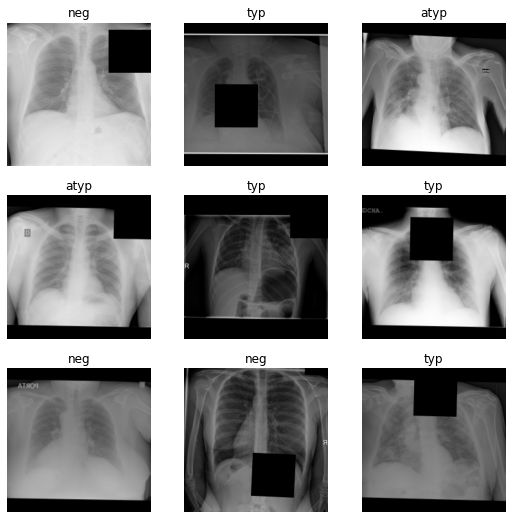

In [8]:
dls_folds[0].show_batch()

In [9]:
learn_folds = [
    train_class.get_learn(dls=dls, model_name=MODEL_NAME, is_neg=False)
    for dls in dls_folds
]

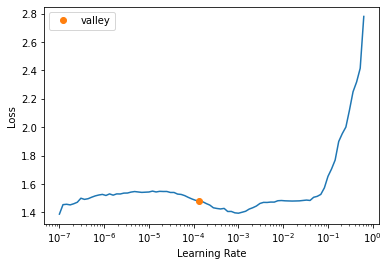

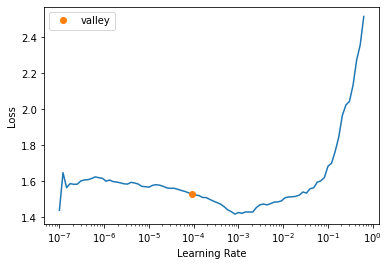

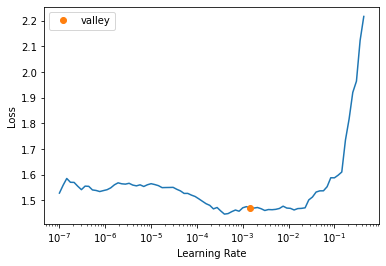

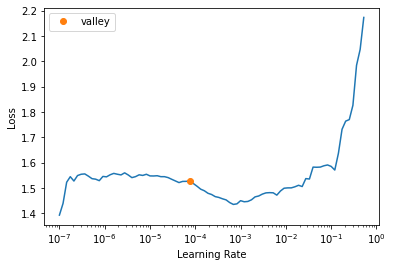

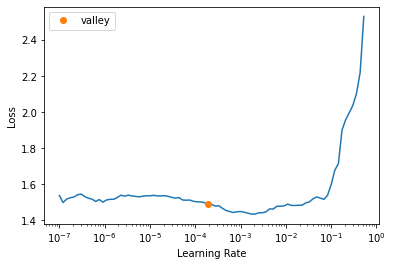

In [187]:
for learn_fold in learn_folds:
    learn_fold.lr_find()

In [10]:
for i, learn in enumerate(learn_folds):
    print(f"Training fold {i}")
    learn.fit_one_cycle(5, 1e-4)
    plt.pause(0.001)

Training fold 0


Training fold 1


Training fold 2


Training fold 3


Training fold 4


In [11]:
train_class.save_learn_folds(
    learn_folds=learn_folds, model_name=MODEL_NAME, is_neg=False
)

In [12]:
preds, targs = train_class.predict_and_save_folds(
    learn_folds=learn_folds, 
    model_name="resnet18", 
    n_tta=0, 
    is_neg=False,
)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:03<00:12,  3.20s/it]

 40%|████      | 2/5 [00:06<00:09,  3.13s/it]

 60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

 80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


In [13]:
train_class.preds_loss(preds, targs)

1.0281431674957275

In [451]:
# Analyze errors

In [452]:
train_class.analyze_accuracy_by_category(
    dls=dls_folds[0], preds=preds_valid, targs=targs_valid
)

mean  count   lab
act                       
0    0.096552    145  atyp
1    0.126126    333   ind
2    0.771593    521   neg
3    0.839424    903   typ

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_folds[0])

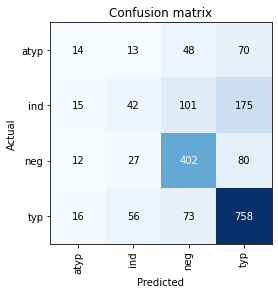

In [518]:
interp.plot_confusion_matrix()

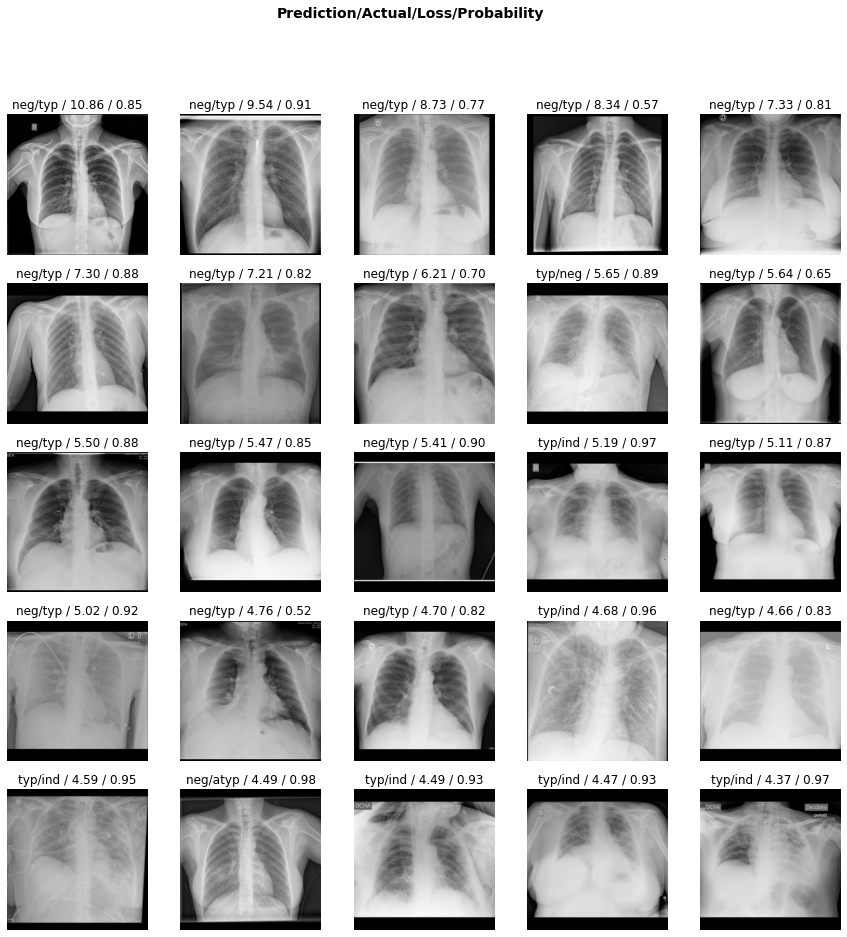

In [517]:
interp.plot_top_losses(25, nrows=5)
# I don't really see any patterns

In [32]:
# LEARN NEG #

In [14]:
NEG_IMAGE_PATH = "png224_5fold"
NEG_NUM_FOLDS = 5
NEG_IMAGE_SIZE = 224
NEG_MODEL_NAME = "resnet18"

In [15]:
neg_dls_folds = [
    train_class.get_dls(
        image_path=NEG_IMAGE_PATH, 
        img_size=NEG_IMAGE_SIZE, 
        is_neg=True, 
        fold_valid=fold,
    )
    for fold in range(NEG_NUM_FOLDS)
]
len(neg_dls_folds[2].train.items), len(neg_dls_folds[2].valid.items), neg_dls_folds[2].vocab, neg_dls_folds[0].one_batch()[0].shape

(5067, 1267, ['negative', 'positive'], torch.Size([32, 3, 224, 224]))

In [16]:
neg_learn_folds = [
    train_class.get_learn(dls=neg_dls, model_name=MODEL_NAME, is_neg=True)
    for neg_dls in neg_dls_folds
]

/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


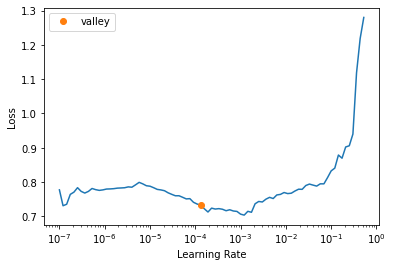

In [17]:
for neg_learn in neg_learn_folds:
    neg_learn.lr_find()

In [18]:
for neg_learn in neg_learn_folds:
    neg_learn.fit_one_cycle(5, 1e-4)

In [23]:
train_class.save_learn_folds(
    learn_folds=neg_learn_folds, model_name=NEG_MODEL_NAME, is_neg=True
)

In [28]:
neg_preds, neg_targs = train_class.predict_and_save_folds(
    learn_folds=neg_learn_folds, 
    model_name="resnet18", 
    n_tta=0, 
    is_neg=True,
)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:11,  2.90s/it]

 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

 60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:11,  2.89s/it]

 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

 60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

 80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


In [25]:
train_class.preds_loss(neg_preds, neg_targs)

0.4668455421924591

In [509]:
train_class.analyze_accuracy_by_category(
    dls=neg_dls_folds[0], preds=neg_preds_valid, targs=neg_targs_valid
)

mean  count       lab
act                           
0    0.715931    521  negative
1    0.892107   1381  positive

In [519]:
neg_interp = ClassificationInterpretation.from_learner(neg_learn_folds[0])

In [520]:
neg_interp.plot_confusion_matrix()

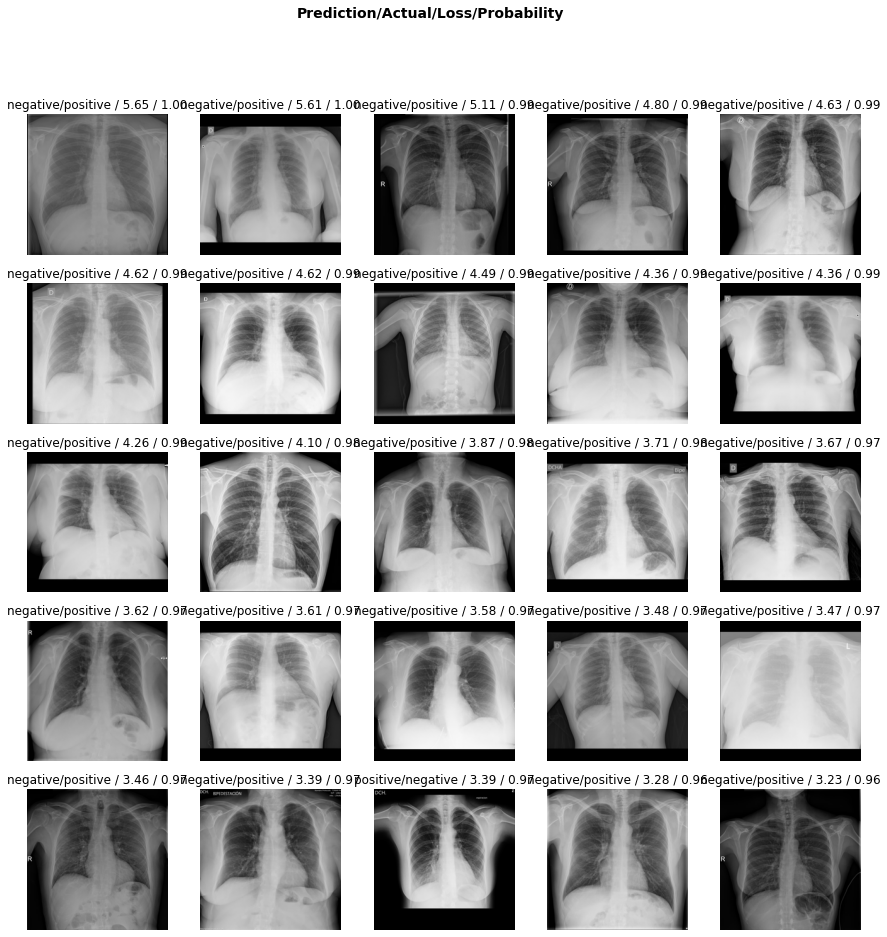

In [521]:
neg_interp.plot_top_losses(25, nrows=5)
# Dang, those confidences are really freaking high